# Markov chain Monte Carlo sampling

## From independent to dependent sampling

In the algorithms we have explored so far (rejection sampling, importance sampling), we draw independent samples from a proposal distribution and compare them to a target distribution.
However, we have seen that this quickly becomes inefficient, particularly in high dimensions.

**Markov chain Monte Carlo** methods address this problem by exploring the target distribution locally instead of globally. 
The idea to to start from an initial point and move through parameter space step by step, proposing new points that are close to the current one.
If we are already in a neighborhood with "good" points, this increases our chances of finding new points that we can accept.
Every proposed point only directly depends on the previous state – this property defines a *Markov chain*, giving the method its name.

At each step, the algorithm decides wether to accept or reject the new point by comparing the target density at the current and the proposed point.

- If the proposed point is more likely, it is accepted.
- If it is less likely, it may still be accepted with some probability.

We need to occasionally accept "worse" points to ensure that we explore the entire target distribution instead of always moving towards the mode of the distribution (or local maxima).
Overall, we must strike a balance between moving far enough to explore new regions and staying close enough to maintain a reasonable acceptance rate.

### Detailed balance

It can be theoretically shown that to strike this balance, the following condition needs to be fulfilled.

The probability of being in state $x$ and transitioning from $x$ to $x^\prime$ must equal the probability of being in state $x^\prime$ and transitioning from $x^\prime$ to $x$.

$$p(x) T(x^\prime \mid x) = p(x^\prime) T(x \mid x^\prime)$$

This is called the *detailed balance condition*

## The Metropolis Hastings algorithm

1. Propose a new point $x^\prime$ based on the current point $x_t$ and a proposal distribution $q(x^\prime \mid x_t)$.
2. Calculate the acceptance probability:
   $$A(x^\prime, x_t) = \min\left(1, \frac{p(x^\prime)}{p(x_t)}\frac{q(x_t \mid x^\prime)}{q(x^\prime \mid x_t}\right)$$
3. Generate a sample $u$ from $U(0, 1)$.
   - If $u \leq A(x^\prime, x_t)$: accept the new state. → $x_{t+1} = x^\prime$.
   - If $u \gt A(x^\prime, x_t)$: reject the new state. → $x_{t+1} = x_t$.
  
With a symmetric proposal distribution, we can simplify the expression for the acceptance probability

$$A(x^\prime, x_t) = \min\left(1, \frac{p(x^\prime)}{p(x_t)}\right)$$



### Animation

The animation below (created by {cite:t}`fengMarkovchainMonteCarlo2025`) illustrate the behavior of a random-walk Metropolis-Hastings sampler for a two-dimensional parameter space.
The blue shaded background and contours show the target distribution.
Dots represent samples.
The two circles around the current sample represent the proposal distribution.
The arrows show the next proposed point. If the arrow turns green, it means that the proposed point is accepted.
If it turns red, the proposed point is rejected.

In the control menu, you can change the standard deviation of the proposal distribution (Algorithm Options → Proposal $\sigma$).
Increase and decrease the standard deviation to explore how this affects sampling.

```{admonition} Animation not working?
:class: note
In case that the animation is not showing, try reloading the page. Alternatively, you can [view the animation here](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=banana).
```


````{div} full-width

<iframe src="https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=banana"
        title="MCMC animation"
        width="100%"
        height="700"></iframe>

````

In [1]:
%config InlineBackend.figure_format = 'svg'

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("../styles/tu_delft.mplstyle")

In [3]:
import scipy.stats as stats
from metropolishastings import sample_metropolis_hastings
import numpy as np
import pandas as pd
from IPython.display import IFrame
from myst_nb import glue

In [4]:
def draw_proposal_sample(x, proposal_cov):
    # Draws a sample from a Normal proposal distribution centered at `x` with standard deviation `proposal_std`
    return stats.multivariate_normal(mean=x, cov=proposal_cov).rvs()


def compute_proposal_logpdf(x, y, proposal_cov):
    # Computes the PDF value of proposing `y` given `x` in the proposal distribution
    return stats.multivariate_normal(mean=x, cov=proposal_cov).logpdf(y)

# Define the target distribution
def evaluate_target_pdf(x):
    """Target distribution with two peaks."""
    return 0.3 * np.exp(-0.2 * (x - 2) ** 2) + 0.7 * np.exp(-0.2 * (x + 2) ** 2)

In [32]:
# Parameters for the algorithm
num_samples = 1000
proposal_cov = 100
start_value = 40

# Run the Metropolis-Hastings algorithm
samples = sample_metropolis_hastings(
    start_value,
    compute_target_logpdf=lambda x: np.log(evaluate_target_pdf(x)),
    compute_proposal_logpdf=compute_proposal_logpdf,
    draw_proposal_sample=draw_proposal_sample,
    num_samples=num_samples,
    proposal_cov=proposal_cov,
)




## Practical considerations

### Burn-in

- Initial samples are still influenced by the starting point and not representative for the distribution
- To speed up convergence, remove these samples: "burn-in" period
- The trace plot in {numref}`fig-mcmc-burnin` shows this behavior: During the first iterations, the sampler moves from the starting point closer to the mode of the distribution. Once it reached the region of higher density, the parameter value fluctuates.


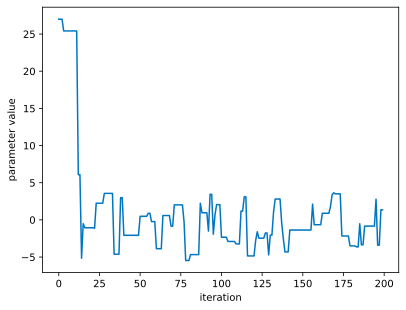

In [33]:
plt.plot(samples[:200])
plt.xlabel("iteration")
plt.ylabel("parameter value")
glue("mcmc_burnin_plot", plt.gcf(), display=False)

```{glue:figure} mcmc_burnin_plot
:width: 100%
:name: "fig-mcmc-burnin"

Traceplot showing the burn-in period of an MCMC simulation. 
```



### Autocorrelation

- the more local approach of MCMC comes at the cost of generating correlated instead of independent samples: Samples are more similar to the ones generated directly before or after them.
- The correlation of samples means that the information content is lower than in the same amount of independent samples → lower effective samples size
- Thinning: only keep every nth sample to reduce autocorrelation



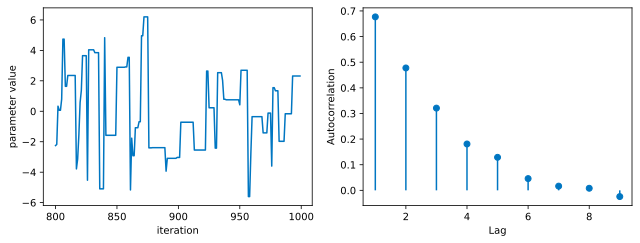

In [34]:
slice = range(800, 1000)

fig, axs = plt.subplots(1, 2, figsize=(9, 3.5))
axs[0].plot(slice, samples[slice])
axs[0].set_xlabel("iteration")
axs[0].set_ylabel("parameter value");


def autocorrelation(x, lag):
    return np.corrcoef(x[:-lag], x[lag:])[0, 1]

# Calculate autocorrelations for each lag
lags = range(1, 10)
autocorrs = [autocorrelation(samples[slice], lag) for lag in lags]

# Plot
axs[1].stem(lags, autocorrs, basefmt=" ")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
glue("mcmc_autocorrelation_plot", plt.gcf(), display=False)

```{glue:figure} mcmc_autocorrelation_plot
:width: 100%
:name: "fig-mcmc-autocorelation"

Trace plot (left) and autocorrelation plot (right) of an MCMC chain. The "plateaus" visible in the left plot show that consecutive samples are often similar.
This is also reflected in the positive autocorrelation (right plot) for lags up to about 5 iterations.
```




### Tuning the proposal distribution

- MH-sampling works better if the proposal distribution is adapted to what the target distribution looks like
- for example, scale the variance of a (symmetric) proposal distribution to influence the step size
- Or use a multivariate normal with covariance as a proposal distribution
- estimate the local covariance from already existing samples
- "adaptive" Metropolis Hastings


### Step size & acceptance rate

- Too small step size: sampler hardly moves, explores distribution very locally. Almost all samples get accepted, but exploring the whole parameter space takes very long → inefficient
- Too large step size: Proposed samples are very far away, basically become random. This leads to a very low acceptance rate  → many samples wasted
- Ideally, step size should be somewhere in between. Theoretical calculations show that an acceptance rate of about 23% is optimal.



In [23]:
# Parameters for the algorithm
num_samples = 1000
proposal_cov = 0.05
start_value = 0

# Run the Metropolis-Hastings algorithm
samples_small_cov = sample_metropolis_hastings(
    start_value,
    compute_target_logpdf=lambda x: np.log(evaluate_target_pdf(x)),
    compute_proposal_logpdf=compute_proposal_logpdf,
    draw_proposal_sample=draw_proposal_sample,
    num_samples=num_samples,
    proposal_cov=proposal_cov,
)

# Parameters for the algorithm
num_samples = 1000
proposal_cov = 2000
start_value = 0

# Run the Metropolis-Hastings algorithm
samples_large_cov = sample_metropolis_hastings(
    start_value,
    compute_target_logpdf=lambda x: np.log(evaluate_target_pdf(x)),
    compute_proposal_logpdf=compute_proposal_logpdf,
    draw_proposal_sample=draw_proposal_sample,
    num_samples=num_samples,
    proposal_cov=proposal_cov,
)



/tmp/ipykernel_85582/1872811529.py:24: RuntimeWarning: divide by zero encountered in log
  compute_target_logpdf=lambda x: np.log(evaluate_target_pdf(x)),


In [24]:
def compute_acceptance_rate(samples):
    return (np.diff(samples[500:]) != 0).mean()

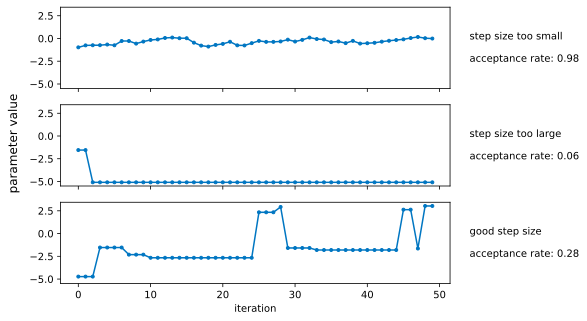

In [25]:
fig, axs = plt.subplots(3, 1, figsize=(7, 5), sharey=True, sharex=True)
axs[0].plot(samples_small_cov[-50:], marker=".", label="step size too small")
axs[0].annotate(
    text=f"step size too small\n\nacceptance rate: {compute_acceptance_rate(samples_small_cov):.2f}",
    xy=(1.05, 0.5),
    xycoords="axes fraction",
    va="center"
)
axs[1].plot(samples_large_cov[-50:], marker=".", label="step size too large")
axs[1].annotate(
    text=f"step size too large\n\nacceptance rate: {compute_acceptance_rate(samples_large_cov):.2f}",
    xy=(1.05, 0.5),
    xycoords="axes fraction",
    va="center"
)
axs[2].plot(samples[-50:], marker=".", label="step size good")
axs[2].annotate(
    text=f"good step size\n\nacceptance rate: {compute_acceptance_rate(samples):.2f}",
    xy=(1.05, 0.5),
    xycoords="axes fraction",
    va="center"
)

plt.xlabel("iteration") 
fig.supylabel("parameter value")

glue("mcmc_acceptance_rate_plot", fig, display=False)

```{glue:figure} mcmc_acceptance_rate_plot
:width: 100%
:name: "fig-mcmc-acceptance-rate"

Trace plot showing the effect of different step sizes on the acceptance rate.
```



## Alternative sampling algorithms

### Gibbs sampling





### Hamiltonian Monte Carlo

 {cite:p}`betancourtConceptualIntroductionHamiltonian2018`

- avoid random walk behavior that leads to local exploration and strong autocorrelation of samples
- to explore the parameter space efficiently, travel along the equipotential lines of the density
- physics simulation in parameter space (like a satellite orbiting a planet)
- uses gradient information (derivative of the target density with respect to parameters)
- See in the animation below how the sampler is often able to "travel" from one end of the target distribution to the other. This creates samples with very little auto-correlation.

````{div} full-width

<iframe src="https://chi-feng.github.io/mcmc-demo/app.html?algorithm=EfficientNUTS&target=banana"
        title="MCMC animation – HMC"
        width="1000"
        height="500"></iframe>

````

### Differential evolution adaptive Metropolis (DREAM)

- The DREAM algorithm {cite:p}`vrugtAcceleratingMarkovChain2009` has been popular in engineering and environmental applications (particularly water resources)
- run several chains in parallel
- chains exchange information → borrows ideas from evolutionary algorithms
- adaptive proposal distribution
- more efficient than plain Metropolis Hastings, particularly in case of correlations while not requiring gradient information